In [1]:
import os, sys, time, random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 12
plt.rcParams["figure.figsize"] = 8, 5

sns.set(rc={"figure.figsize": (8, 5)})
sns.set(style="darkgrid")

print('Numpy version:', np.version.version)

# Set working dir to project root
while not os.getcwd().endswith("hw2_kws"):
    os.chdir(os.pardir)

Numpy version: 1.22.3


### Steps to reproduce model

1. Run all cells of `seminar.ipynb`
2. Run `python bin/create_streaming_jit.py`
3. Run `python bin/stream.py`

On MacOS `python bin/stream.py -d :0 -f avfoundation`

On Linux `python bin/stream.py -d hw:0 -f alsa`

On Windows `python bin/stream.py -d audio=YOUR_DEVICE -f dshow`

### 1. Streaming

Генерируем случайный файл с ключевым словом посередине

In [3]:
N = 20
seed = 42

datadir = 'C:/Users/foma/Downloads/speech_commands/'
dirs = [d for d in os.listdir(datadir) if os.path.isdir(datadir + d) and not d.startswith("_")]
dirs.sort()

np.random.seed(seed)
random.seed(seed)

with open("resources/data/test_pieces.txt", "w") as file:
    for i in range(N):
        if i == N // 2:
            d = "sheila"
        else:
            d = np.random.choice(dirs)
        f = np.random.choice(list(sorted(os.listdir(datadir + d))))
        file.write("file 'file:" + datadir + d + "/" + f + "'\n")

In [4]:
!ffmpeg -f concat -safe 0 -i resources/data/test_pieces.txt resources/data/test.wav

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 9.2.1 (GCC) 20200122
  configuration: --disable-static --enable-shared --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt
  libavutil 

Запускаем стриминг

In [40]:
!python bin/stream.py -d resources/data/test.wav -f s16le -r > resources/output/test_result.txt

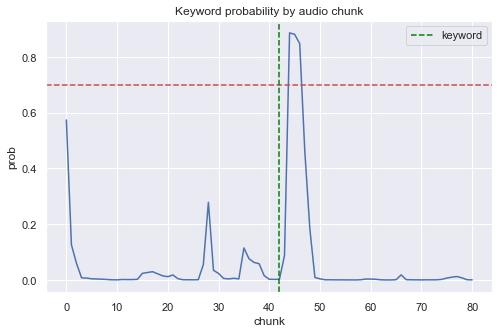

In [5]:
probs = [float(v) for v in open("resources/output/test_result.txt", "r").readlines()]
plt.plot(probs)
plt.axhline(y=0.7, color='r', linestyle='--')
plt.axvline(x=42, color='green', linestyle='--', label="keyword")
plt.xlabel("chunk")
plt.ylabel("prob")
plt.legend()
plt.title("Keyword probability by audio chunk")

plt.show()

### Анализ

Был написан код, сохраняющий выходы GRU и выровненный с шагом свертки. Однако, он не заработал, поэтому было решено быстро докинуть аккумулятор на весь вход. Так заработало.